In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2



In [2]:


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')

df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
METRIC = "I(X_1->X_2)/d_2"

table = make_table_pivot(METRIC, df)

METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)', 'Reranking Average (4 datasets)']

mteb = pd.read_csv('exported_data/df_mteb_avg.csv')

import re

def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]

mteb['model'] = mteb['Model'].apply(extract_url_from_html_link).apply(lambda x: "/".join(x.split('/')[-2:]))

avg_results = table.median(axis=1).sort_values(ascending=False).to_frame().reset_index().rename(columns={0: METRIC, 'model_1': 'model'}).merge(mteb, on='model', how='left').sort_values(METRIC, ascending=False)

# make model shorter
avg_results['model'] = avg_results['model'].apply(lambda x: x.split('/')[-1])



/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


In [3]:
mteb_info = avg_results[['model', METRIC]+METRICS].set_index('model')

In [4]:

classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

print(len(classifcation_df['dataset'].unique()))

classifcation_df = classifcation_df.groupby('model').mean().reset_index()

pivoted_classif = classifcation_df[['model','success']].set_index('model') # .pivot_table(index='model', columns='dataset', values='success')

pivoted_classif = pivoted_classif.rename(columns={'success': 'Classification 2 (8 datasets)'})
pivoted_classif.index = pivoted_classif.index.map(lambda x: x.split('/')[-1])

9


/tmp/ipykernel_396257/711521119.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  classifcation_df = classifcation_df.groupby('model').mean().reset_index()


In [5]:


pearson = pd.merge(mteb_info, pivoted_classif, left_index=True, right_index=True).corr(method="pearson").loc[METRIC, :].sort_values(ascending=False)
spearman = pd.merge(mteb_info, pivoted_classif, left_index=True, right_index=True).corr(method="spearman").loc[METRIC, :].sort_values(ascending=False)
kendall = pd.merge(mteb_info, pivoted_classif, left_index=True, right_index=True).corr(method="kendall").loc[METRIC, :].sort_values(ascending=False)

correlations = pd.concat([pearson, spearman, kendall], axis=1, keys=['$\\rho_p$', '$\\rho_s$', '$\\tau$']).sort_values('$\\rho_s$', ascending=False)


correlations = correlations.drop(index=METRIC)

import re
# Remove "Average" from the names

# correlations.index = correlations.index.map(lambda x: re.sub(r'\s\(\d+ datasets\)', '', x))


In [6]:

map_to_index_group = {'Average (56 datasets)': 'MTEB', 'Classification Average (12 datasets)': 'sub mteb', 'Clustering Average (11 datasets)': 'sub mteb', 'Retrieval Average (15 datasets)': 'sub mteb', 'STS Average (10 datasets)': 'sub mteb', 'Reranking Average (4 datasets)': 'sub mteb', 'Classification 2 (8 datasets)': 'Additional'}

correlations_ = correlations.reset_index().rename(columns={'index': ' '})
correlations_['Group'] = correlations_[' '].map(map_to_index_group)

# remove "Average" from the names
correlations_[' '] = correlations_[' '].map(lambda x: re.sub(r'\sAverage', '', x))

correlations_ = correlations_.set_index(['Group', ' '])
correlations_ = correlations_.loc[['sub mteb', 'MTEB', 'Additional']]
display(correlations_)
# correlations.index = correlations.index.map(lambda x: re.sub(r'\sAverage', '', x))

style = correlations_.style.format(precision=2)
style = style.hide(axis="index",level=0, names=True)

# Make Average bold
style = style.applymap((lambda x: 'bfseries:'), subset=(pd.IndexSlice[:, "Average (56 datasets)"], ) )
# same for index
style

$\rho_p$  $\rho_s$    $\tau$
Group                                                                 
sub mteb   Retrieval (15 datasets)        0.887840  0.886096  0.696552
           Classification (12 datasets)   0.919162  0.879074  0.727273
           Clustering (11 datasets)       0.858201  0.850501  0.668966
           STS (10 datasets)              0.916495  0.819446  0.621404
           Reranking (4 datasets)         0.838149  0.787319  0.641379
MTEB       Average (56 datasets)          0.937388  0.900211  0.736479
Additional Classification 2 (8 datasets)  0.890683  0.841100  0.661319

,$\rho_p$,$\rho_s$,$\tau$
Retrieval (15 datasets),0.89,0.89,0.70
Classification (12 datasets),0.92,0.88,0.73
Clustering (11 datasets),0.86,0.85,0.67
STS (10 datasets),0.92,0.82,0.62
Reranking (4 datasets),0.84,0.79,0.64
Average (56 datasets),0.94,0.90,0.74
Classification 2 (8 datasets),0.89,0.84,0.66


In [7]:

path = Path(f"../../../papers/emir-embedding-comparison/tables/nlp/{PREFIX}_overall_correlation_table_{sanitize_metric_name(METRIC)}.tex")
path.parent.mkdir(parents=True, exist_ok=True)
latex = style.to_latex(clines="skip-last;data", sparse_index=True, hrules=True)

# insert double hline before Average (56 datasets)
latex = latex.replace("Average (56 datasets)", "\midrule\midrule\nAverage (56 datasets)")
# insert double hline before Classification 2 (8 datasets)
latex = latex.replace("Classification 2 (8 datasets)", "\midrule\midrule\nClassification 2 (8 datasets)")

# rename classification 2
latex = latex.replace("Classification 2 (8 datasets)", "Additional Classif (8 datasets)")

print(latex)


# save the latex
path.write_text(latex)


\begin{tabular}{lrrr}
\toprule
 & $\rho_p$ & $\rho_s$ & $\tau$ \\
\midrule
Retrieval (15 datasets) & 0.89 & 0.89 & 0.70 \\
Classification (12 datasets) & 0.92 & 0.88 & 0.73 \\
Clustering (11 datasets) & 0.86 & 0.85 & 0.67 \\
STS (10 datasets) & 0.92 & 0.82 & 0.62 \\
Reranking (4 datasets) & 0.84 & 0.79 & 0.64 \\
\midrule\midrule
Average (56 datasets) & \bfseries 0.94 & \bfseries 0.90 & \bfseries 0.74 \\
\midrule\midrule
Additional Classif (8 datasets) & 0.89 & 0.84 & 0.66 \\
\bottomrule
\end{tabular}


506

# Correlation heatmap model / metrics

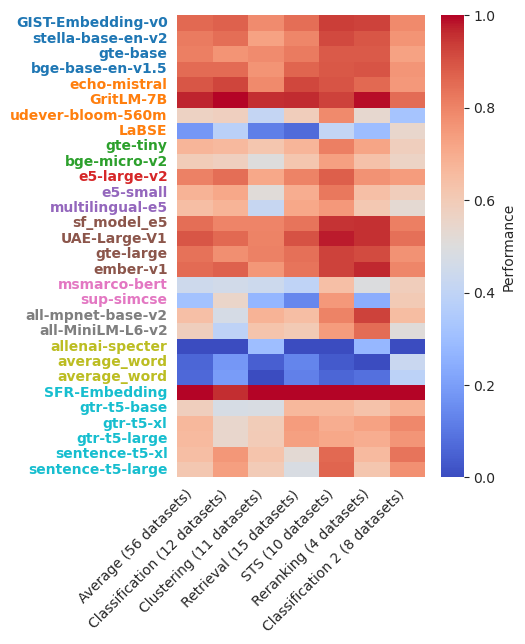

In [59]:
from scipy.cluster.hierarchy import linkage, dendrogram


perfs = pd.merge(mteb_info, pivoted_classif*100, left_index=True, right_index=True).dropna().drop(columns=METRIC)

communities = make_communities_from_table(table)
# apply short names
communities = {k.split('/')[-1] : v for k, v in communities.items()}
perfs['community'] = perfs.index.map(lambda x: communities[x])

perfs = perfs.sort_values('community')
_perfs = perfs.drop(columns='community')

# normalize _perfs columns by columns
# _perfs = (_perfs - _perfs.mean()) / _perfs.std()
_perfs = (_perfs - _perfs.min()) / (_perfs.max() - _perfs.min())

fig, ax = plt.subplots(figsize=(4, 6))
sns.heatmap(_perfs, ax=ax, annot=False, cmap='coolwarm', cbar_kws={'label': 'Performance'})

# color ytick labels by community
yticks = ax.get_yticklabels()
new_yticks = []
for i, ytick in enumerate(yticks):
    text = ytick.get_text()
    if len(text) > 20:
        if len(text.split('_')) > 1:
            text = "_".join(text.split('_')[:2])
        elif len(text.split('/')) > 1:
            text = "/".join(text.split('/')[:2])
        elif len(text.split('-')) > 1:
            text = "-".join(text.split('-')[:2])
            
    new_yticks.append(text)
    


ax.set_yticklabels(new_yticks)  

yticks = ax.get_yticklabels()

for i, ytick in enumerate(yticks):
    ytick.set_color(f"C{perfs['community'].iloc[i]}")
    # set fontweight to bold for the community name
    ytick.set_fontweight('bold')
    
# Remove \sAverage from the names
xticks = ax.get_xticklabels()
xticks = [re.sub(r'\sAverage', '', x.get_text()) for x in xticks]
ax.set_xticklabels(xticks, rotation=45, ha='right')
    
ax.set_ylabel('')

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_tasks_perfs_community_heatmap.pdf")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
# fig.tight_layout()
fig.savefig(path, bbox_inches='tight', dpi=300)
